# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 06 - Arquiteturas CNN mais populares 2

Vamos preparar os dados para poder applicar mais algumas arquiteturas de classificação de imagens:

In [ ]:
!pip install geopandas
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 70.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.windows import Window
import pandas as pd
import geopandas as gpd
from pylab import rcParams
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 18, 6
from sklearn.model_selection import train_test_split
from rasterio.plot import show
from shapely.geometry import box

Vamos definir os caminhos:

In [ ]:
path_img = '/content/drive/MyDrive/Datasets/Veg_Level_classification/Multiespectral-termal - Ortomosaico RGB.tif'
path_pontos = '/content/drive/MyDrive/Datasets/Veg_Level_classification/Pontos.shp'

Nesse exemplo vamos gerar um dataset a partir dos pontos e da imagem. Cada ponto tem uma classificação de densidade de vegetação. Foram criados 3 classes: Baixo, Médio e Alto.

In [ ]:
gdf = gpd.read_file(path_pontos)

<Axes: >

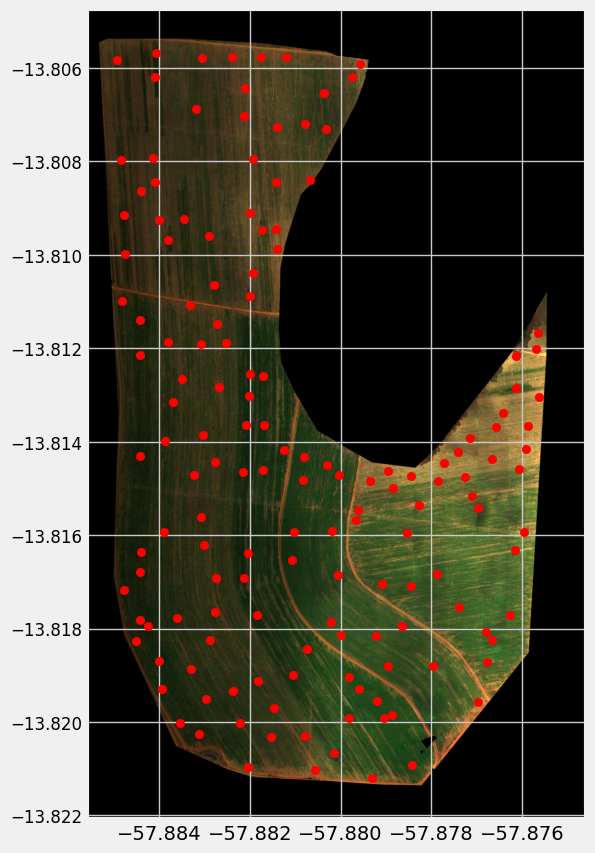

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(path_img) as src:
    gdf = gdf.to_crs(src.crs.to_dict())
    show(src,ax=ax)
gdf.plot(ax=ax, color='red')

Para cada ponto vamos gerar uma imagem com o tamanho de 256x256 pixels usando o ponto com centro.

In [ ]:
src = rasterio.open(path_img)
im = src.read()

In [ ]:
im = im.transpose([1,2,0])

In [ ]:
im.shape

(3853, 2442, 4)

In [ ]:
im = im.astype('uint8')

In [ ]:
img_list = []
label_list = []
for i,pt in gdf.iterrows():
  x = pt['geometry'].xy[0][0]
  y = pt['geometry'].xy[1][0]
  label = pt['id']
  row, col = src.index(x,y)
  img_path = im[row-64:row+64,col-64:col+64,0:3]


  img_list.append(img_path)
  label_list.append(label)


Agora, vamos converter as listas de imagens e de dados de referências em numpy arrays:

In [ ]:
X = np.array(img_list)
Y = np.array(label_list)

In [ ]:
X.shape

(152, 128, 128, 3)

In [ ]:
Y.shape

(152,)

Também criamos um dicionário para nomear as classes e plotamos um exemplo:

In [ ]:
dict_name = {0:'Baixo', 1: 'Medio', 2:'Alto'}

(-0.5, 127.5, 127.5, -0.5)

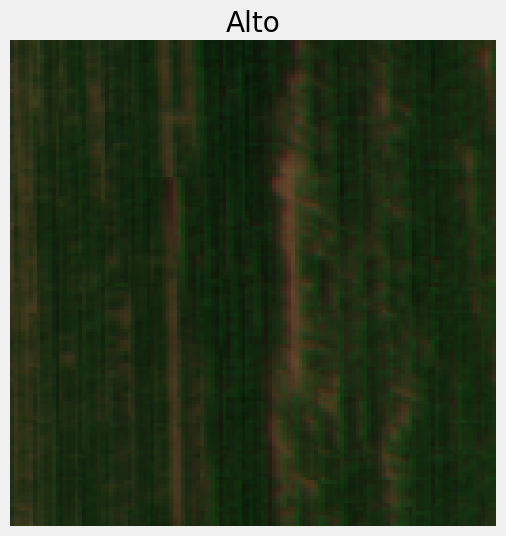

In [ ]:
i = 20
plt.figure(figsize=[6,6])
plt.title(dict_name[Y[i]])
plt.imshow(img_list[i])
plt.axis('off')

Convertemos os valores das imagens para o intervalo entre 0 e 1 e aplicamos o one hot encoding nos labels. Por fim dividimos os dados em treinamento e teste:

In [ ]:
X = X/255

In [ ]:
from keras.utils import to_categorical

In [ ]:
Y = to_categorical(Y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
input_shape = x_train.shape[1:]
n_classes = 3

## ResNet

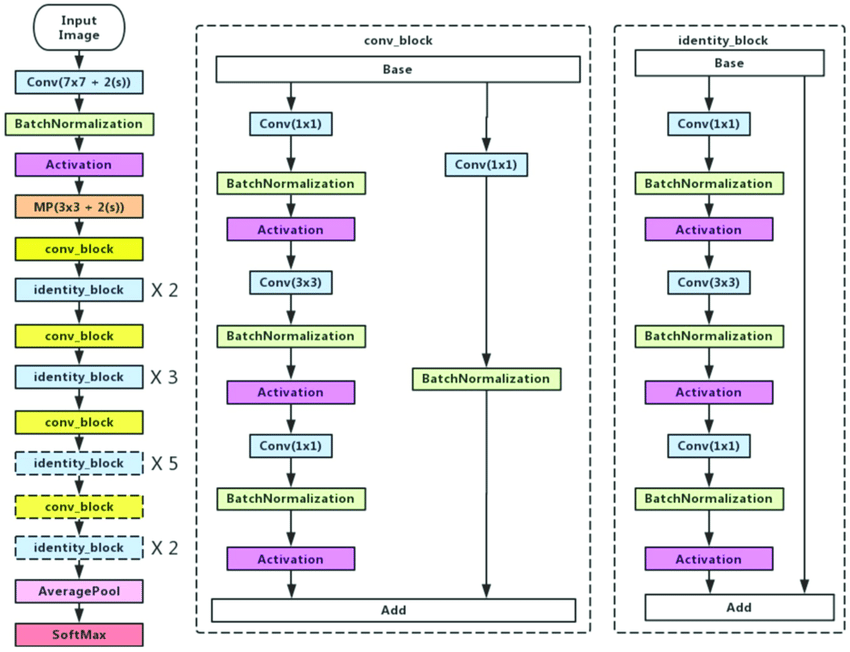

ResNet, abreviação de Residual Networks, é uma rede neural clássica usada como backbone para muitas tarefas de visão computacional. Este modelo foi o vencedor do desafio ImageNet em 2015. O avanço fundamental com ResNet foi que nos permitiu treinar redes neurais extremamente profundas com mais de 150 camadas com sucesso. Antes do ResNet, o treinamento de redes neurais muito profundas era difícil devido ao problema de desaparecimento de gradientes. A AlexNet, vencedora do ImageNet 2012 e o modelo que aparentemente iniciou o foco em deep learning tinha apenas 8 camadas convolucionais, a rede VGG tinha 19 e a Inception ou GoogleNet tinha 22 camadas e a ResNet 152 tinha 152 camadas. Neste blog, codificaremos um ResNet-50 que é uma versão menor do ResNet 152 e frequentemente usado como ponto de partida para aprendizagem por transferência.

A ResNet introduziu pela primeira vez o conceito de skip connection. O diagrama abaixo ilustra a conexão de salto. A figura à esquerda está empilhando camadas de convolução uma após a outra. À direita, ainda empilhamos as camadas de convolução como antes, mas agora também adicionamos a entrada original à saída do bloco de convolução. Isso é chamado de skip connection:

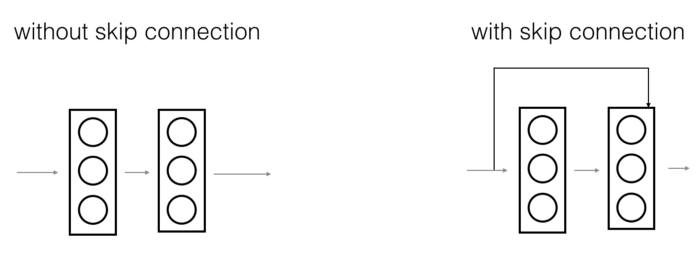

Como X, X_shortcut acima são duas matrizes, você pode adicioná-las somente se tiverem a mesma forma. Portanto, se as operações de convolução + batch normalization forem feitas de forma que a forma de saída seja a mesma, podemos simplesmente adicioná-las conforme mostrado abaixo.

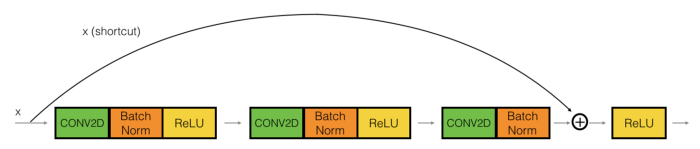

Caso contrário, o x_shortcut passa por uma camada de convolução escolhida de forma que a saída dela tenha a mesma dimensão que a saída do bloco de convolução, conforme mostrado abaixo:

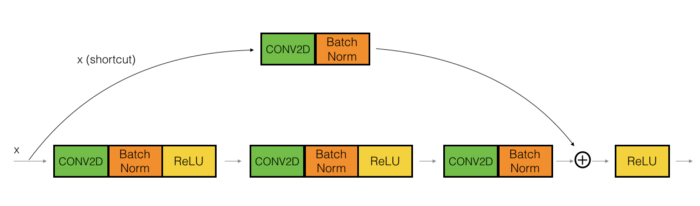

Esta é uma pergunta interessante. Acho que há duas razões pelas quais as conexões Skip funcionam aqui:
- Eles atenuam o problema de desaparecimento do gradiente, permitindo que esse caminho de atalho alternativo para o gradiente flua
- Eles permitem que o modelo aprenda uma função de identidade que garante que a camada superior terá um desempenho pelo menos tão bom quanto a camada inferior, e não pior

Vamos aplicar a Resnet nos nossos dados:

In [ ]:
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras import initializers
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=initializers.glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=input_shape)

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1')(headModel)
headModel=Dense(128, activation='relu', name='fc2')(headModel)
headModel = Dense(n_classes,activation='softmax', name='fc3')(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001, decay=1e-6), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 64)   9472        ['zero_padding2d_3[0][0]']       
                                                                                            

In [ ]:
history = model.fit(x = x_train, y= y_train, batch_size=16, epochs=300, verbose=1, shuffle=True, validation_split= 0.3)

Epoch 1/300
5/5 [==============================] - 7s 415ms/step - loss: 1.1727 - accuracy: 0.4595 - val_loss: 1.0946 - val_accuracy: 0.1562
Epoch 2/300
5/5 [==============================] - 0s 41ms/step - loss: 1.0260 - accuracy: 0.4730 - val_loss: 1.0914 - val_accuracy: 0.3750
Epoch 3/300
5/5 [==============================] - 0s 42ms/step - loss: 0.9313 - accuracy: 0.5541 - val_loss: 1.0910 - val_accuracy: 0.3750
Epoch 4/300
5/5 [==============================] - 0s 43ms/step - loss: 0.9518 - accuracy: 0.5541 - val_loss: 1.0857 - val_accuracy: 0.3750
Epoch 5/300
5/5 [==============================] - 0s 42ms/step - loss: 0.9272 - accuracy: 0.6081 - val_loss: 1.0813 - val_accuracy: 0.4375
Epoch 6/300
5/5 [==============================] - 0s 42ms/step - loss: 0.8960 - accuracy: 0.6351 - val_loss: 1.0798 - val_accuracy: 0.3750
Epoch 7/300
5/5 [==============================] - 0s 41ms/step - loss: 0.7399 - accuracy: 0.7432 - val_loss: 1.0794 - val_accuracy: 0.3750
Epoch 8/300
5/5 [==

### Xception

Xception é uma arquitetura de rede neural convolucional profunda que envolve convoluções separáveis em profundidade. Foi desenvolvido por pesquisadores do Google. O Google apresentou uma interpretação dos módulos Inception em redes neurais convolucionais como sendo uma etapa intermediária entre a convolução regular e a operação de convolução separável em profundidade (uma convolução em profundidade seguida por uma convolução pontual). Uma convolução separável em profundidade pode ser entendida como um módulo de Iniciação com um número máximo de torres. Essa observação os leva a propor uma nova arquitetura de rede neural convolucional profunda inspirada em Inception, onde os módulos Inception foram substituídos por convoluções separáveis em profundidade.

###Original Depthwise Separable Convolution:

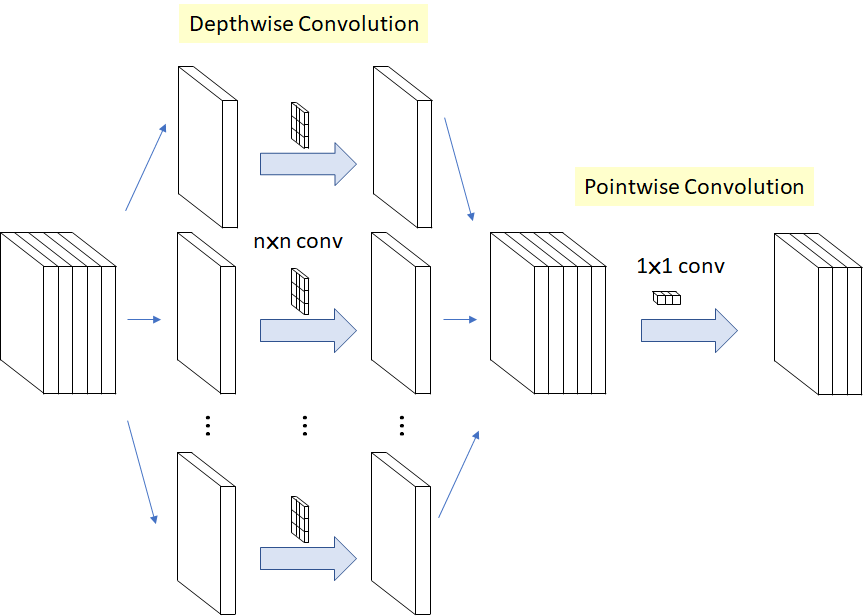

A convolução original separável em profundidade é a convolução em profundidade seguida por uma convolução pontual.
- A convolução em profundidade é a convolução espacial n×n por canal. Suponha que na figura acima, temos 5 canais, então teremos 5 convoluções espaciais n×n.
- Na verdade, a convolução pontual é a convolução 1 × 1 para alterar a dimensão.
Em comparação com a convolução convencional, não precisamos realizar a convolução em todos os canais. Isso significa que o número de conexões é menor e o modelo é mais leve.

###Modified Depthwise Separable Convolution in Xception:

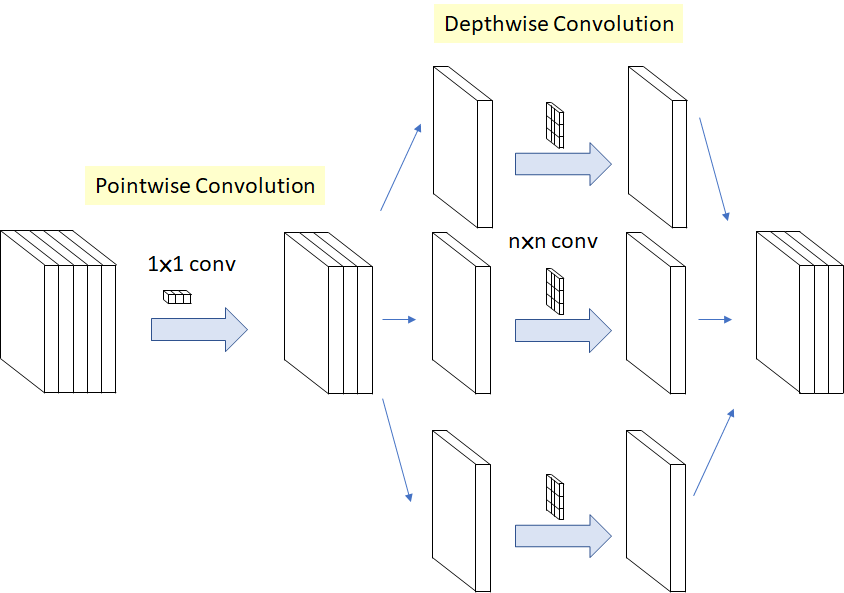

A convolução separável em profundidade modificada é a convolução pontual seguida por uma convolução em profundidade. Esta modificação é motivada pelo módulo de inception em Inception-v3 que a convolução 1 × 1 é feita primeiro antes de quaisquer convoluções espaciais n × n. Assim, é um pouco diferente do original. (n=3 aqui, já que convoluções espaciais 3 × 3 são usadas em Inception-v3.)
Duas pequenas diferenças:
- A ordem das operações: como mencionado, as convoluções separáveis em profundidade originais, como geralmente implementadas (por exemplo, no TensorFlow), executam primeiro a convolução espacial por canal e, em seguida, realizam a convolução 1 × 1, enquanto a convolução separável em profundidade modificada executa primeiro a convolução 1 × 1 e depois o canal -wise convolução espacial. Isso é considerado sem importância porque quando é usado em configuração empilhada, existem apenas pequenas diferenças que aparecem no início e no final de todos os módulos de iniciação encadeados.
- A Presença/Ausência de Não Linearidade: No Módulo de Iniciação original, há não linearidade após a primeira operação. Em Xception, a convolução separável em profundidade modificada, NÃO há não-linearidade ReLU intermediária.

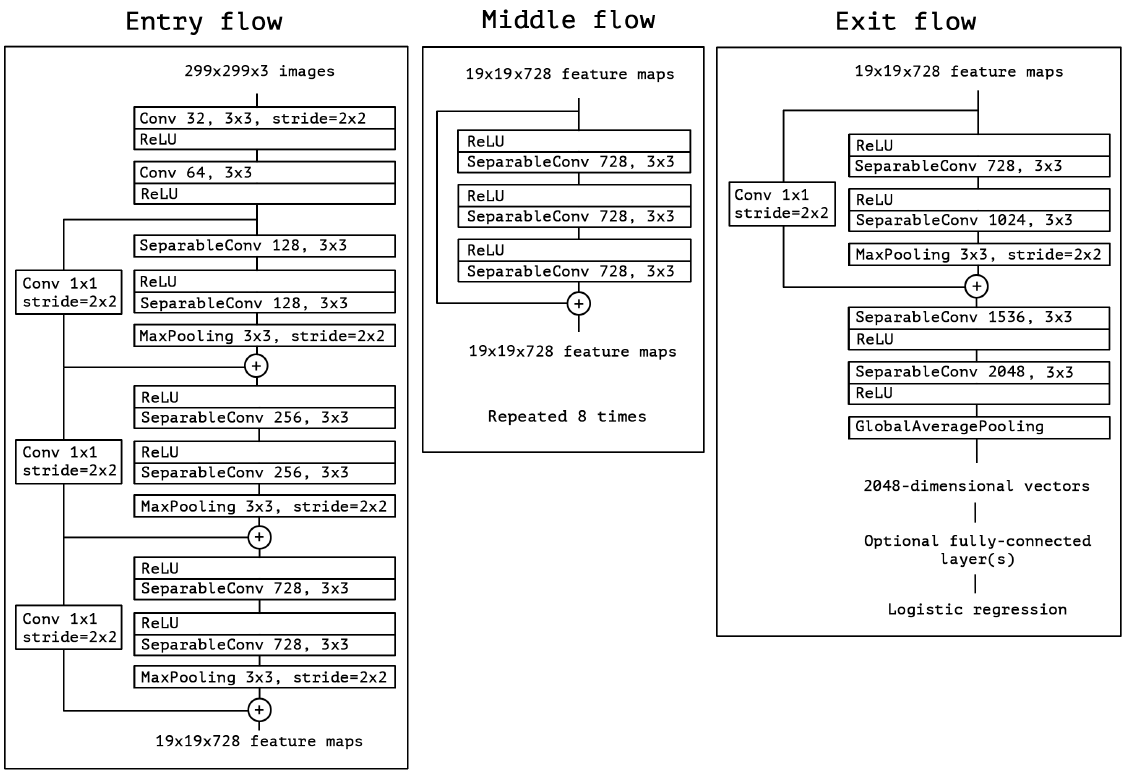

Vamos ver como essa arquitetura se sai nos mesmos dados usados acima:

In [ ]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

In [ ]:
def Xception():

	img_input = Input(shape=input_shape)

	# Block 1
	x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = Conv2D(64, (3, 3), use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 2
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 2 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 3
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 3 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 4
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 5 - 12
	for i in range(8):
		residual = x

		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)

		x = layers.add([x, residual])

	residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 13
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 13 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 14
	x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Block 14 part 2
	x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Fully Connected Layer
	x = GlobalAveragePooling2D()(x)
	x = Dense(n_classes, activation='softmax')(x)

	inputs = img_input

	# Create model
	model = Model(inputs, x, name='xception')


	return model

In [ ]:
model = Xception()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001, decay=1e-6), metrics=['accuracy'])
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 activation_10 (Activation)     (None, 8, 8, 728)    0           ['add_3[0][0]']                  
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 8, 8, 728)   536536      ['activation_10[0][0]']          
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 8, 8, 728)   2912        ['separable_conv2d_9[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 8, 8, 728)    0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 separable

In [ ]:
history = model.fit(x = x_train, y= y_train, batch_size=16, epochs=300, verbose=1, shuffle=True, validation_split= 0.3)

Epoch 1/300
5/5 [==============================] - 17s 369ms/step - loss: 1.1103 - accuracy: 0.3919 - val_loss: 1.0985 - val_accuracy: 0.3750
Epoch 2/300
5/5 [==============================] - 0s 47ms/step - loss: 0.9763 - accuracy: 0.6351 - val_loss: 1.0984 - val_accuracy: 0.3750
Epoch 3/300
5/5 [==============================] - 0s 47ms/step - loss: 0.9468 - accuracy: 0.6351 - val_loss: 1.0983 - val_accuracy: 0.3750
Epoch 4/300
5/5 [==============================] - 0s 46ms/step - loss: 0.8728 - accuracy: 0.7297 - val_loss: 1.0982 - val_accuracy: 0.4062
Epoch 5/300
5/5 [==============================] - 0s 47ms/step - loss: 0.7745 - accuracy: 0.8649 - val_loss: 1.0981 - val_accuracy: 0.4062
Epoch 6/300
5/5 [==============================] - 0s 47ms/step - loss: 0.7349 - accuracy: 0.8784 - val_loss: 1.0980 - val_accuracy: 0.4062
Epoch 7/300
5/5 [==============================] - 0s 49ms/step - loss: 0.6803 - accuracy: 0.8784 - val_loss: 1.0979 - val_accuracy: 0.4062
Epoch 8/300
5/5 [=

Após o treinamento vamos usar o modelo para verificar a acurácia nos dados de teste:

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predict = model.predict(x_test)
pred = np.argmax(predict, axis=1)
true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(true,pred)
print(accuracy)

2/2 [==============================] - 0s 17ms/step
0.8913043478260869


Vamos agora dividir a imagem completa em patches de 128x128 e classificar cada um desse pedaços da imagem:

In [ ]:
path_img_to_pred = '/content/drive/MyDrive/Datasets/Veg_Level_classification/Multiespectral-termal - Ortomosaico RGB.tif'
path_split = "/content/split_img"
if not os.path.isdir(path_split):
    os.mkdir(path_split)

In [ ]:
src = rasterio.open(path_img_to_pred)
out_meta = src.meta.copy()
qtd = 0
for n in range((src.meta['width']//128)):
  for m in range((src.meta['height']//128)):
    x = ((n*128))
    y = ((m*128))
    window = Window(x,y,128,128)
    win_transform = src.window_transform(window)
    arr_win = src.read(window=window)
    if arr_win.max() != 0:
      qtd = qtd + 1
      path_exp_img = os.path.join(path_split, 'img_' + str(qtd) + '.tif')
      out_meta.update({"driver": "GTiff","height": arr_win.shape[1],"width": arr_win.shape[2], "compress":'lzw', "transform":win_transform})
      with rasterio.open(path_exp_img, 'w', **out_meta) as dst:
          for i, layer in enumerate(arr_win, start=1):
              dst.write_band(i, layer.reshape(-1, layer.shape[-1]))
      print('Create img: ' + str(qtd))
    del arr_win

Create img: 1
Create img: 2
Create img: 3
Create img: 4
Create img: 5
Create img: 6
Create img: 7
Create img: 8
Create img: 9
Create img: 10
Create img: 11
Create img: 12
Create img: 13
Create img: 14
Create img: 15
Create img: 16
Create img: 17
Create img: 18
Create img: 19
Create img: 20
Create img: 21
Create img: 22
Create img: 23
Create img: 24
Create img: 25
Create img: 26
Create img: 27
Create img: 28
Create img: 29
Create img: 30
Create img: 31
Create img: 32
Create img: 33
Create img: 34
Create img: 35
Create img: 36
Create img: 37
Create img: 38
Create img: 39
Create img: 40
Create img: 41
Create img: 42
Create img: 43
Create img: 44
Create img: 45
Create img: 46
Create img: 47
Create img: 48
Create img: 49
Create img: 50
Create img: 51
Create img: 52
Create img: 53
Create img: 54
Create img: 55
Create img: 56
Create img: 57
Create img: 58
Create img: 59
Create img: 60
Create img: 61
Create img: 62
Create img: 63
Create img: 64
Create img: 65
Create img: 66
Create img: 67
Crea

In [ ]:
n = [f for f in os.listdir(path_split)]

In [ ]:
df_full = pd.DataFrame([])
for path_img in n:
  img = []
  path_full = os.path.join(path_split,path_img)
  ds = rasterio.open(path_full, 'r')
  im = ds.read()
  im = im.transpose([1,2,0])
  im = im[:,:,0:3]
  im = im/255
  im = im[np.newaxis,:,:,:]
  predict = model.predict(im)
  predict = np.argmax(predict, axis=1)
  geom = box(*ds.bounds)
  df = gpd.GeoDataFrame({"id":1,'classe':predict[0],"geometry":[geom]})
  df_full = pd.concat([df_full,df])


1/1 [==============================] - 0s 21ms/step


O resultado gerado é um dataframe com os poligonos respresentando as áreas das imagens:

In [ ]:
df_full

,id,classe,geometry
0,1,2,"POLYGON ((-57.88386 -13.81972, -57.88386 -13.8..."
0,1,2,"POLYGON ((-57.88041 -13.81338, -57.88041 -13.8..."
0,1,2,"POLYGON ((-57.87983 -13.80820, -57.87983 -13.8..."
0,1,2,"POLYGON ((-57.87983 -13.81396, -57.87983 -13.8..."
0,1,2,"POLYGON ((-57.88098 -13.81338, -57.88098 -13.8..."
...,...,...,...
0,1,1,"POLYGON ((-57.88213 -13.81165, -57.88213 -13.8..."
0,1,2,"POLYGON ((-57.88156 -13.81281, -57.88156 -13.8..."
0,1,2,"POLYGON ((-57.88041 -13.81972, -57.88041 -13.8..."
0,1,2,"POLYGON ((-57.88386 -13.81741, -57.88386 -13.8..."


Vamos plotar esse dataframe para ver o resultado:

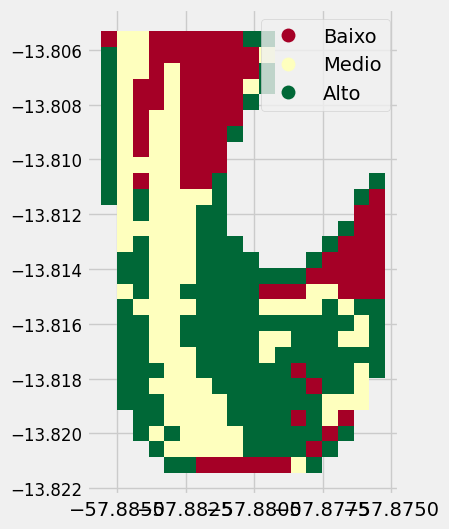

In [ ]:
ax = df_full.plot("classe",legend=True, cmap='RdYlGn',categorical=True)

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), dict_name)

In [ ]:
df_full.to_file('veg_classification.json')